# Pipeline 1: Participants and single trial EEG artifact screening and exclusion

garv_screen = artifacts tagged by experimenter visual inspection

eeg_screen = artifacts tagged as blinks by experimenter and/or blocking and peak-to-peak excursion algorithm

Global EEG_SCREEN_COL `eeg_screen` is used to exclude EEG artifacts prior to modeling and label HDF5 dataset

In [1]:
from pathlib import Path
import logging
import os
import re
import datetime
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns


import matplotlib as mpl
RC_PARAMS = dict(mpl.rcParams)
from matplotlib import pyplot as plt

import fitgrid
import fitgrid.utils as fgutil

from udck19_filenames import (
    EEG_EXPT_FILES, 
    EEG_EPOCHS_DIR, 
    EEG_MODELING_DIR, 
    PREPOCHS_ALL_F, 
    PREPOCHS_TRMD_EEG_F,
    SUB_INFO_F
)

from udck19_utils import (
    get_udck19_logger,
    check_ENV,
    N_EPOCH_SAMPS,  # epoch length in samples
    N_PREPOCHS_ALL,  # number of recorded single trial epochs
    N_TRMD_EEG_EPOCHS,  # number of epochs after EEG screening below
    EEG_SCREEN_COL,  # artifact tag column name == screened HDF5 dataset key
    EEG_EXPT_SPECS, 
    EEG_26_STREAMS, 
    RHS_VARS,
    check_epochs_shape, 
    standardize,
    udck19_figsave,
    FIG_TAG_SPECS,
)

# enforce conda env
check_ENV()

# logging config
__file__ = 'udck19_pipeline_1.ipynb'
logging.shutdown()
LOGGER = get_udck19_logger(__file__)

pipeline_start = datetime.datetime.now()

LOGGER.info(f"""
udck19 Supplementary Materials 1
CONDA_DEFAULT_ENV: {os.environ['CONDA_DEFAULT_ENV']}
pandas: {pd.__version__} 
fitgrid: {fitgrid.__version__}
Start {pipeline_start.strftime("%d.%b %Y %H:%M:%S")}
""")

/home/turbach/.conda/envs/udck19_pnas_110819/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  del sys.path[0]
udck19_pipeline_1.ipynb:INFO:
udck19 Supplementary Materials 1
CONDA_DEFAULT_ENV: udck19_pnas_110819
pandas: 0.25.2 
fitgrid: 0.4.6
Start 15.Dec 2019 17:31:52



# Notebook globals

In [2]:
FIG_PREFIX = f"udck19_pipeline_1 Fig"
FIG_COUNT = 1

# Participant age and comprehension summary

age  comprehension_correct
udck19                                        
Exp1   count  32.000000              32.000000
       mean   21.343750               0.946875
       std     5.045658               0.047003
       min    18.000000               0.760000
       25%    18.000000               0.935000
       50%    20.000000               0.960000
       75%    21.000000               0.980000
       max    37.000000               1.000000
Exp2   count  32.000000              32.000000
       mean   19.406250               0.960625
       std     1.387952               0.038849
       min    18.000000               0.850000
       25%    18.000000               0.930000
       50%    19.000000               0.970000
       75%    21.000000               1.000000
       max    23.000000               1.000000
Exp3   count  24.000000              24.000000
       mean   19.916667               0.940000
       std     1.767254               0.043539
       min    18.000000               0.790000
       25%    19.000000               0.927500
       50%    19.500000               0.960000
       75%    21.000000               0.962500
       max    26.000000               0.980000

,age,comprehension_correct
count,88.00000,88.000000
mean,20.25000,0.950000
std,3.36394,0.043576
min,18.00000,0.760000
25%,18.00000,0.930000
50%,19.00000,0.960000
75%,21.00000,0.980000
max,37.00000,1.000000


sex
udck19           
Exp1   count   32
       unique   2
       top      F
       freq    23
Exp2   count   32
       unique   2
       top      F
       freq    23
Exp3   count   24
       unique   2
       top      F
       freq    12

,sex
count,88
unique,2
top,F
freq,58


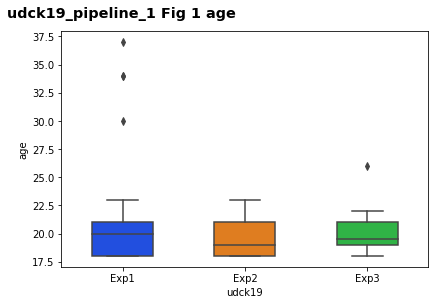

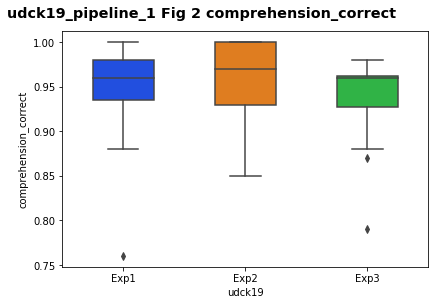

In [3]:
sub_info = (
    pd.read_csv(SUB_INFO_F).set_index("udck19")[["age", "sex", "comprehension_correct"]]
)

# tables
for dt in [np.number, np.object]:
    display(sub_info.groupby("udck19").describe(include=dt).stack())
    display(sub_info.describe(include=dt))


# figures
for col in ["age", "comprehension_correct"]:
    f, ax = plt.subplots()
    sns.boxplot(
        x="udck19", y=col, ax=ax, data=sub_info.reset_index(), 
        width=0.5, palette="bright"
    )

    title_str = f"{FIG_PREFIX} {FIG_COUNT} {col}"
    plt.suptitle(title_str, **FIG_TAG_SPECS)
    f.tight_layout()
    FIG_COUNT = udck19_figsave(f, title_str, FIG_COUNT)

# Load all prepared epochs

In [4]:
LOGGER.info(f"Loading {PREPOCHS_ALL_F}")
prepochs_df = pd.read_hdf(PREPOCHS_ALL_F, key='prepochs_all')

# enforce epoch dimensions as dumped by single trial wrangling
assert (N_EPOCH_SAMPS, N_PREPOCHS_ALL) == check_epochs_shape(prepochs_df)

msg = f"""
All prepared EEG epochs across 3 expts
    timestamps: {N_EPOCH_SAMPS}, epochs {N_PREPOCHS_ALL}
    index names: {prepochs_df.index.names}
    columns: {prepochs_df.columns}
"""
LOGGER.info(msg)

udck19_pipeline_1.ipynb:INFO:Loading /mnt/cube/home/turbach/papers/udck19/analysis/data/epochs/prepochs_all.h5
udck19_pipeline_1.ipynb:INFO:
All prepared EEG epochs across 3 expts
    timestamps: 375, epochs 13258
    index names: ['Epoch_idx', 'expt', 'sub_id', 'item_id', 'Time']
    columns: Index(['h5_dataset', 'dataset_index', 'event_code', 'regex_match',
       'regex_anchor', 'garv_reject', 'article', 'adjective', 'noun',
       'article_cloze', 'ART_noun_cloze', 'NA_noun_cloze', 'lle', 'lhz',
       'MiPf', 'LLPf', 'RLPf', 'LMPf', 'RMPf', 'LDFr', 'RDFr', 'LLFr', 'RLFr',
       'LMFr', 'RMFr', 'LMCe', 'RMCe', 'MiCe', 'MiPa', 'LDCe', 'RDCe', 'LDPa',
       'RDPa', 'LMOc', 'RMOc', 'LLTe', 'RLTe', 'LLOc', 'RLOc', 'MiOc', 'A2',
       'HEOG', 'rle', 'rhz', 'article_item_id', 'ptp_excursion', 'blocked',
       'garv_blink', 'garv_screen', 'eeg_screen'],
      dtype='object')



In [5]:
LOGGER.info(prepochs_df.head())
LOGGER.info(prepochs_df.tail())

udck19_pipeline_1.ipynb:INFO:                                                          h5_dataset  \
Epoch_idx expt  sub_id   item_id            Time                       
10000     eeg_1 arquan01 i005_1_a__NA_check -1496  arquan01/dblock_1   
                                            -1488  arquan01/dblock_1   
                                            -1480  arquan01/dblock_1   
                                            -1472  arquan01/dblock_1   
                                            -1464  arquan01/dblock_1   

                                                   dataset_index  event_code  \
Epoch_idx expt  sub_id   item_id            Time                               
10000     eeg_1 arquan01 i005_1_a__NA_check -1496          11318           0   
                                            -1488          11320           0   
                                            -1480          11322           0   
                                            -1472          11324  

# Tabulate EEG artifact rejections by subject and item

In [6]:
events = prepochs_df.query("Time==0")  # artifacts tagged at article event codes, i.e., Time == 0

rejects = {}
rejects_summary = {}
for art_rejects in [EEG_SCREEN_COL]:
    # load reject descriptive stats 
    rejects[art_rejects] = dict()
    
    # value_counts counts what it finds, so nothing for 0 counts (these are rare)
    # unstacking introduces nans for the missing data, fix by setting nan fill_val = 0 counts. 
    rejects[art_rejects].update(
        {
            'rejects': (
                events.groupby(['expt'])[art_rejects]
                .value_counts()
                .unstack(-1, fill_value=0)  
            )
        }
    )
    
    # by subject
    rejects[art_rejects].update(
        {
            'by_sub': (
                events.groupby(['expt', 'sub_id'])[art_rejects]
                .value_counts()
                .unstack(-1, fill_value=0)
            )
        }
    )
    
    # by item
    rejects[art_rejects].update(
        {
            'by_item': (
                events.groupby(['expt', 'item_id'])[art_rejects].
                value_counts()
                .unstack(-1, fill_value=0)
            )
        }
    )
    
    # summarize
    rejects_summary = dict()
    for by, reject_df in rejects[art_rejects].items():
        reject_df['n'] = reject_df['accept'] + reject_df['reject']
        reject_df['rej_rate'] = reject_df['reject'] / reject_df['n']
        
        summary = reject_df.groupby('expt')['rej_rate'].describe().T
        summary['by'] = by
        summary.set_index('by', append=True, inplace=True)
        
        # capture
        rejects_summary.update({by:  summary})

    rejects[art_rejects]['summary'] = rejects_summary


# rejection summaries
for art_rejects, results in rejects.items():
    LOGGER.info(art_rejects)
    LOGGER.info(results['rejects'])
    LOGGER.info(results['summary']['by_sub'])
    LOGGER.info(results['summary']['by_item'])
    

udck19_pipeline_1.ipynb:INFO:eeg_screen
udck19_pipeline_1.ipynb:INFO:eeg_screen  accept  reject     n  rej_rate
expt                                      
eeg_1         2136     403  2539  0.158724
eeg_2         4668     339  5007  0.067705
eeg_3         5239     473  5712  0.082808
udck19_pipeline_1.ipynb:INFO:expt              eeg_1      eeg_2      eeg_3
      by                                     
count by_sub  32.000000  32.000000  24.000000
mean  by_sub   0.158481   0.067724   0.082850
std   by_sub   0.174878   0.103888   0.072415
min   by_sub   0.000000   0.000000   0.004184
25%   by_sub   0.025000   0.012739   0.032427
50%   by_sub   0.096686   0.030211   0.048523
75%   by_sub   0.202532   0.071993   0.128410
max   by_sub   0.762500   0.452229   0.282700
udck19_pipeline_1.ipynb:INFO:expt                eeg_1       eeg_2       eeg_3
      by                                         
count by_item  159.000000  631.000000  476.000000
mean  by_item    0.158805    0.067523    0.08280

In [7]:
# single trial counts and rejections by participant
with pd.option_context('display.max_rows', None):
    display(rejects[EEG_SCREEN_COL]['by_sub'])

eeg_screen      accept  reject    n  rej_rate
expt  sub_id                                 
eeg_1 arquan01      76       3   79  0.037975
      arquan02      79       1   80  0.012500
      arquan03      72       7   79  0.088608
      arquan04      78       2   80  0.025000
      arquan05      78       1   79  0.012658
      arquan06      78       2   80  0.025000
      arquan07      63      16   79  0.202532
      arquan08      78       2   80  0.025000
      arquan09      75       4   79  0.050633
      arquan10      75       5   80  0.062500
      arquan11      69      10   79  0.126582
      arquan12      53      27   80  0.337500
      arquan13      71       8   79  0.101266
      arquan14      66      14   80  0.175000
      arquan15      79       0   79  0.000000
      arquan16      51      29   80  0.362500
      arquan17      35      44   79  0.556962
      arquan18      19      61   80  0.762500
      arquan19      63      16   79  0.202532
      arquan20      69       7   76  0.092105
      arquan21      72       7   79  0.088608
      arquan22      79       1   80  0.012500
      arquan23      65      14   79  0.177215
      arquan24      52      28   80  0.350000
      arquan25      74       5   79  0.063291
      arquan26      63      16   79  0.202532
      arquan27      59      20   79  0.253165
      arquan28      51      29   80  0.362500
      arquan29      65      14   79  0.177215
      arquan30      80       0   80  0.000000
      arquan31      79       0   79  0.000000
      arquan32      70      10   80  0.125000
eeg_2 arcadj01      95      60  155  0.387097
      arcadj02     145      12  157  0.076433
      arcadj03     151       5  156  0.032051
      arcadj04     137      20  157  0.127389
      arcadj05     147      10  157  0.063694
      arcadj06     149       8  157  0.050955
      arcadj07     145      11  156  0.070513
      arcadj08     155       2  157  0.012739
      arcadj10     157       0  157  0.000000
      arcadj11     151       5  156  0.032051
      arcadj12     142      15  157  0.095541
      arcadj13     153       4  157  0.025478
      arcadj14     135       4  139  0.028777
      arcadj15     156       2  158  0.012658
      arcadj16     133      24  157  0.152866
      arcadj17     157       1  158  0.006329
      arcadj19     156       2  158  0.012658
      arcadj20     147       5  152  0.032895
      arcadj21     142      15  157  0.095541
      arcadj22     152       4  156  0.025641
      arcadj24     158       0  158  0.000000
      arcadj25     126      32  158  0.202532
      arcadj26      86      71  157  0.452229
      arcadj27     153       5  158  0.031646
      arcadj28     158       0  158  0.000000
      arcadj29     151       7  158  0.044304
      arcadj30     154       3  157  0.019108
      arcadj31     155       3  158  0.018987
      arcadj32     154       4  158  0.025316
      arcadj33     155       3  158  0.018987
      arcadj34     155       2  157  0.012739
      arcadj35     158       0  158  0.000000
eeg_3 yan01        236       3  239  0.012552
      yan02        229      10  239  0.041841
      yan03        234       3  237  0.012658
      yan04        233       4  237  0.016878
      yan05        224      15  239  0.062762
      yan06        170      67  237  0.282700
      yan07        214      25  239  0.104603
      yan08        210      29  239  0.121339
      yan09        202      35  237  0.147679
      yan10        234       5  239  0.020921
      yan11        238       1  239  0.004184
      yan12        185      52  237  0.219409
      yan13        224      13  237  0.054852
      yan14        207      32  239  0.133891
      yan15        228       9  237  0.037975
      yan16        227      10  237  0.042194
      yan17        200      39  239  0.163180
      yan18        232       7  239  0.029289
      yan19        228       9  237  0.037975
      yan20        213      24  237  0.101266
      yan21        231       8  239  0.03347

In [8]:
# single trial counts and rejections by experiment and item
with pd.option_context('display.max_rows', None):
    display(rejects[EEG_SCREEN_COL]['by_item'])

eeg_screen                                  accept  reject   n  rej_rate
expt  item_id                                                           
eeg_1 i001_1_a__NA_carrot                       14       2  16  0.125000
      i001_1_an_NA_apple                        11       5  16  0.312500
      i002_1_a__NA_carrot                       15       1  16  0.062500
      i002_1_an_NA_apple                        14       2  16  0.125000
      i003_1_a__NA_lisp                         12       4  16  0.250000
      i003_1_an_NA_accent                       12       4  16  0.250000
      i004_1_a__NA_lisp                         11       5  16  0.312500
      i004_1_an_NA_accent                       14       2  16  0.125000
      i005_1_a__NA_check                        11       5  16  0.312500
      i005_1_an_NA_apology                      13       3  16  0.187500
      i006_1_a__NA_check                        10       6  16  0.375000
      i006_1_an_NA_apology                      12       4  16  0.250000
      i007_1_a__NA_kite                         13       3  16  0.187500
      i007_1_an_NA_airplane                     14       2  16  0.125000
      i008_1_a__NA_kite                         14       2  16  0.125000
      i008_1_an_NA_airplane                     16       0  16  0.000000
      i009_1_a__NA_bird                         14       2  16  0.125000
      i009_1_an_NA_echo                         13       3  16  0.187500
      i010_1_a__NA_bird                         15       1  16  0.062500
      i010_1_an_NA_echo                         14       2  16  0.125000
      i011_1_a__NA_fish                         14       2  16  0.125000
      i011_1_an_NA_octopus                      13       3  16  0.187500
      i012_1_a__NA_fish                         13       3  16  0.187500
      i012_1_an_NA_octopus                      16       0  16  0.000000
      i015_1_a__NA_student                      16       0  16  0.000000
      i015_1_an_NA_artist                       13       3  16  0.187500
      i016_1_a__NA_student                      11       5  16  0.312500
      i016_1_an_NA_artist                       11       5  16  0.312500
      i019_1_a__NA_book                         13       3  16  0.187500
      i019_1_an_NA_education                    13       3  16  0.187500
      i020_1_a__NA_book                         11       5  16  0.312500
      i020_1_an_NA_education                    13       3  16  0.187500
      i021_1_a__NA_parade                       10       5  15  0.333333
      i021_1_an_NA_election                     13       3  16  0.187500
      i022_1_a__NA_parade                       14       2  16  0.125000
      i022_1_an_NA_election                     11       5  16  0.312500
      i023_1_a__NA_fight                        15       1  16  0.062500
      i023_1_an_NA_affair                       13       3  16  0.187500
      i024_1_a__NA_fight                        15       1  16  0.062500
      i024_1_an_NA_affair                       14       2  16  0.125000
      i025_1_a__NA_dollar                       14       2  16  0.125000
      i025_1_an_NA_allowance                    16       0  16  0.000000
      i026_1_a__NA_dollar                       13       3  16  0.187500
      i026_1_an_NA_allowance                    11       5  16  0.312500
      i029_1_a__NA_fire                         15       1  16  0.062500
      i030_1_a__NA_fire                         14       2  16  0.125000
      i030_1_an_NA_emergency                    11       5  16  0.312500
      i031_1_a__NA_hanger                       12       4  16  0.250000
      i031_1_an_NA_iron                         14       2  16  0.125000
      i032_1_a__NA_hanger                       12       4  16  0.250000
      i032_1_an_NA_iron                         14       2  16  0.125000
      i033_1_a__NA_race                         15       1  16  0.062500
      i033_1_an_NA_accident                     14       2

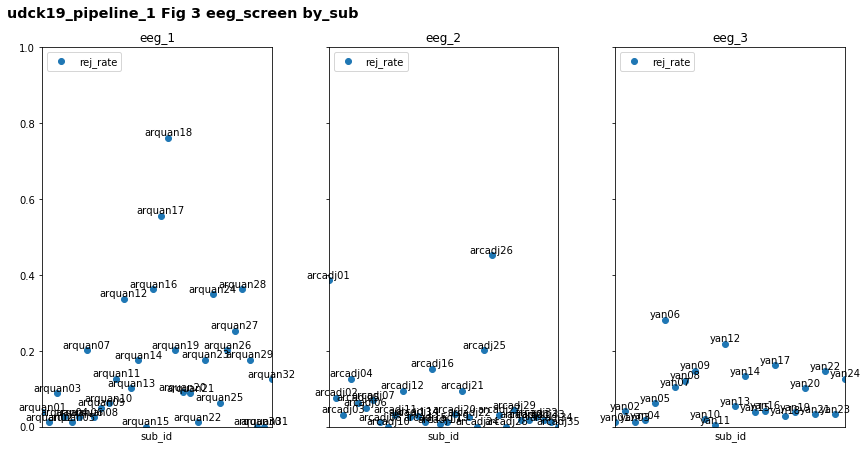

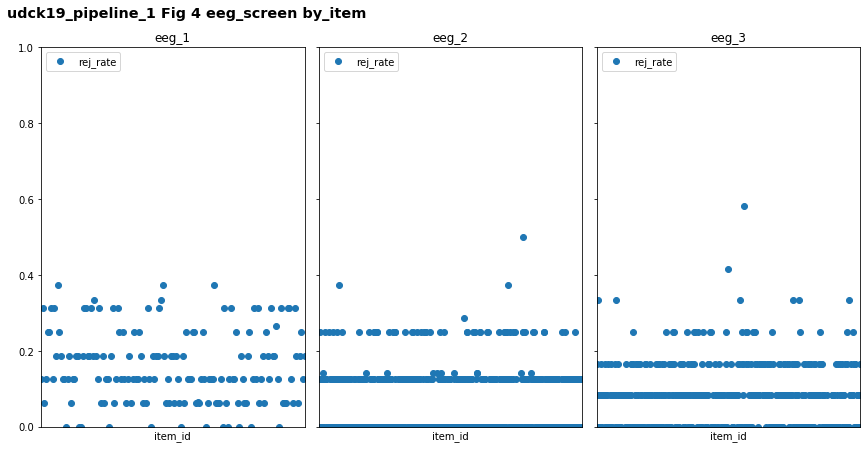

In [9]:
plt.close('all')
for by in ['by_sub', 'by_item']:
    rejects_by = rejects[EEG_SCREEN_COL][by]

    f, axs = plt.subplots(1, 3, sharey=True, figsize=(12,6))
    for aidx, (expt, rejects_by) in enumerate(rejects_by.groupby('expt')):
        iax = axs[aidx]
        iax.set_title(f"{expt}")
        iax.set(ylim=(0, 1))
        iax.xaxis.set_ticks([])

        if by == 'by_sub':
            x_key = 'sub_id'
        elif by == 'by_item':
            x_key = 'item_id'
        else:
            raise ValueError(x_key)

        rejects_by.reset_index().plot(
            ax=iax, x=x_key, y='rej_rate', lw=0, marker='o'
        )

        if by == 'by_sub':
            for row_idx, ((expt, sub_id), row), in enumerate(rejects_by.iterrows()):
                #print(row_idx, sub_id, row['rej_rate'])
                iax.text(x=row_idx, 
                        y=row['rej_rate'], s=sub_id,
                        verticalalignment='bottom',
                        horizontalalignment='center'
                   )
        iax.legend(loc='upper left')

    title_str = f"{FIG_PREFIX} {FIG_COUNT} {EEG_SCREEN_COL} {by}"
    plt.suptitle(title_str, **FIG_TAG_SPECS)
    f.tight_layout()
    FIG_COUNT = udck19_figsave(f, title_str, FIG_COUNT)


# Distribution of article cloze by artifact screening

* Counts showing distribution of accepted (many) vs. rejected (few) trials

* Normalized with accepted and rejected on the same scale shows the cloze distribution for accepted and rejected trials is generally similar.


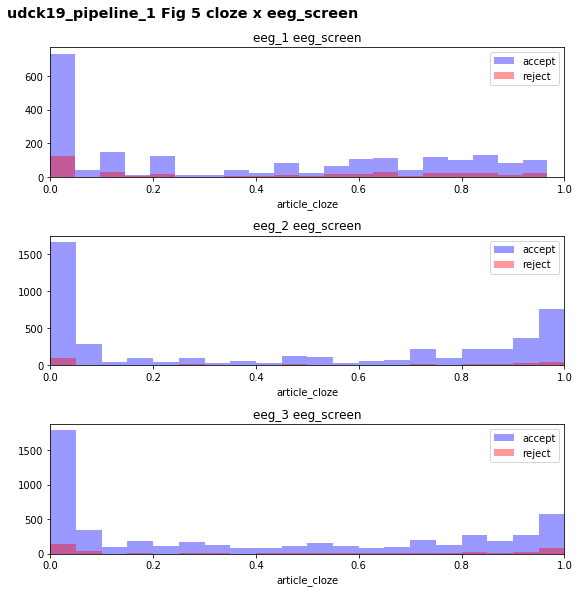

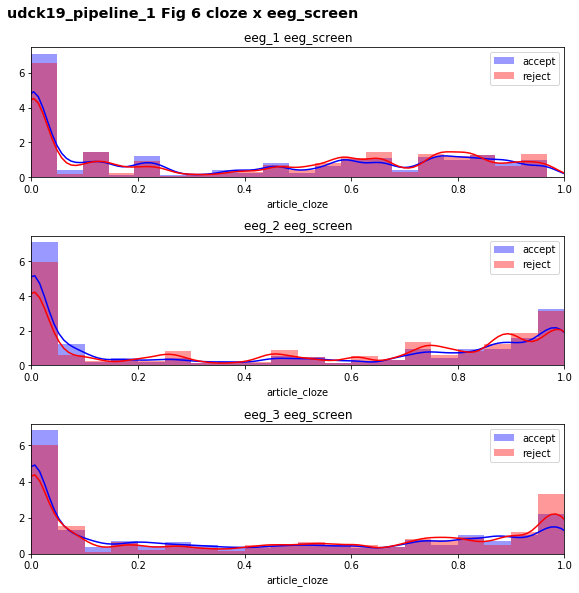

In [10]:
for show_kde in [False, True]:

    f, axs = plt.subplots(3, figsize=(8,8))

    idx = 0
    for expt, exp_data in events.groupby('expt'):
        ax = axs[idx]
        idx += 1
        ax.set_xlim(0, 1)
        ax.set_prop_cycle(mpl.cycler(color=['blue', 'red']))

        for screen_val, data in exp_data.groupby(EEG_SCREEN_COL):
            sns.distplot(
                data['article_cloze'], 
                ax=ax, 
                bins=20, 
                kde_kws={"bw": 0.025},
                label=f"{screen_val}",
                kde=show_kde,
            )
        ax.set_title(f"{expt} {EEG_SCREEN_COL}")
        ax.legend()

    sup_title = f"{FIG_PREFIX} {FIG_COUNT} cloze x {EEG_SCREEN_COL}"
    f.suptitle(sup_title, **FIG_TAG_SPECS)
    f.tight_layout()
    FIG_COUNT = udck19_figsave(f, sup_title, FIG_COUNT)

# Drop EEG artifacts and save for modeling

In [11]:
# slicer to choose good epochs
qstr = f"{EEG_SCREEN_COL} == 'accept'"
prepochs_trmd_eeg_df = prepochs_df.query(qstr).copy()
prepochs_trmd_eeg_df.index = prepochs_trmd_eeg_df.index.remove_unused_levels()

assert (N_EPOCH_SAMPS, N_TRMD_EEG_EPOCHS) == check_epochs_shape(prepochs_trmd_eeg_df)

msg = f"""
Prepared epochs after dropping EEG artifacts tagged in column: {EEG_SCREEN_COL}
    timestamps: {N_EPOCH_SAMPS}, epochs {N_TRMD_EEG_EPOCHS}
    index names: {prepochs_trmd_eeg_df.index.names}
    columns: {prepochs_trmd_eeg_df.columns}
"""
LOGGER.info(msg)

# write to HDF5
LOGGER.info(f"""
Writing EEG screend data epochs to HDF5:
{PREPOCHS_TRMD_EEG_F}, key={EEG_SCREEN_COL}
""")

prepochs_trmd_eeg_df.to_hdf(PREPOCHS_TRMD_EEG_F, EEG_SCREEN_COL, mode='w')
LOGGER.info(" done")

udck19_pipeline_1.ipynb:INFO:
Prepared epochs after dropping EEG artifacts tagged in column: eeg_screen
    timestamps: 375, epochs 12043
    index names: ['Epoch_idx', 'expt', 'sub_id', 'item_id', 'Time']
    columns: Index(['h5_dataset', 'dataset_index', 'event_code', 'regex_match',
       'regex_anchor', 'garv_reject', 'article', 'adjective', 'noun',
       'article_cloze', 'ART_noun_cloze', 'NA_noun_cloze', 'lle', 'lhz',
       'MiPf', 'LLPf', 'RLPf', 'LMPf', 'RMPf', 'LDFr', 'RDFr', 'LLFr', 'RLFr',
       'LMFr', 'RMFr', 'LMCe', 'RMCe', 'MiCe', 'MiPa', 'LDCe', 'RDCe', 'LDPa',
       'RDPa', 'LMOc', 'RMOc', 'LLTe', 'RLTe', 'LLOc', 'RLOc', 'MiOc', 'A2',
       'HEOG', 'rle', 'rhz', 'article_item_id', 'ptp_excursion', 'blocked',
       'garv_blink', 'garv_screen', 'eeg_screen'],
      dtype='object')

udck19_pipeline_1.ipynb:INFO:
Writing EEG screend data epochs to HDF5:
/mnt/cube/home/turbach/papers/udck19/analysis/data/epochs/prepochs_trimd_eeg.h5, key=eeg_screen

/home/turbach/.con

# Article cloze values by item and experiment

In [12]:
# get the unique item ids and their cloze
item_events_df = (
    prepochs_trmd_eeg_df
    .query("Time==0")['article_cloze']
    .reset_index(["sub_id", "Epoch_idx", "Time"], drop=True)
    .reset_index(["item_id"])
)
assert item_events_df.shape == (N_TRMD_EEG_EPOCHS, 2)

# slice out the article prefix from the item id
item_events_df["article_id"] = (
    item_events_df["item_id"]
    .apply(lambda x: re.match(r"^(?P<art_id>i\d\d\d_[12]_a[n_]).*", x)["art_id"])
)
assert item_events_df.shape == (N_TRMD_EEG_EPOCHS, 3)

# this stacks unique items by experiment so items 1-160 overlap in eeg_2, eeg_3
# (except for items in that range excluded for stim presentation coding errors)
article_cloze = []
for (expt, data) in item_events_df.groupby('expt'):
    article_cloze.append(data.drop_duplicates('article_id'))
article_cloze_df = pd.concat(article_cloze)
article_cloze_df = article_cloze_df[["article_id", "article_cloze"]]
article_cloze_df = article_cloze_df.sort_values("article_id")
assert article_cloze_df.shape == (951, 2)

## Article cloze, all contexts `i_NNN_N`

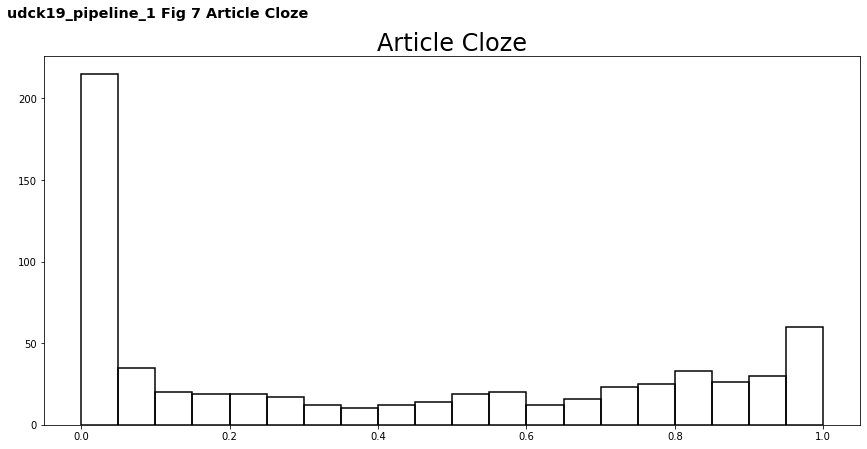

In [14]:
article_item_ids = (
    article_cloze_df.reset_index(drop=True)
    .drop_duplicates('article_id')
    .sort_values('article_id')
)

f, ax = plt.subplots(figsize=(12,6))
ax.hist(
    article_item_ids['article_cloze'],
    bins=20,
    lw=1.5,
    facecolor='none',
    edgecolor='black'
)
suptitle = f"{FIG_PREFIX} {FIG_COUNT} Article Cloze"
f.suptitle(suptitle, **FIG_TAG_SPECS)
f.tight_layout()
FIG_COUNT = udck19_figsave(f, suptitle, FIG_COUNT)

In [15]:
with pd.option_context("display.max_rows", None):
    LOGGER.info(article_item_ids.drop_duplicates())    

udck19_pipeline_1.ipynb:INFO:    article_id  article_cloze
0    i001_1_a_          0.033
1    i001_1_an          0.800
2    i001_2_a_          0.000
4    i001_2_an          0.742
6    i002_1_a_          0.966
7    i002_1_an          0.000
8    i002_2_a_          1.000
10   i002_2_an          0.000
12   i003_1_a_          0.207
13   i003_1_an          0.759
14   i003_2_a_          0.000
16   i003_2_an          0.935
18   i004_1_a_          0.821
19   i004_1_an          0.036
20   i004_2_a_          0.871
22   i004_2_an          0.000
24   i005_1_a_          0.033
25   i005_1_an          0.900
26   i005_2_a_          0.258
28   i005_2_an          0.742
30   i006_1_a_          0.929
31   i006_1_an          0.000
32   i006_2_a_          0.968
34   i006_2_an          0.032
36   i007_1_a_          0.393
37   i007_1_an          0.500
38   i007_2_a_          0.032
40   i007_2_an          0.968
42   i008_1_a_          0.857
43   i008_1_an          0.000
44   i008_2_a_          1.000
46   i008_2

## Article item ids and cloze by Experiment

* By design Experiments 1, 2, and 3 have 80, 160, 240 contexts = 160, 320, 480 a/an pairs  

* The number of distinct items in the pooled data is less than the sum (480 contexts, a/an pairs) b.c.

  1. Expt 2, 3 share 160 contexts, Expt 3 adds 80 more so by design: 80 + 160 + 80 = 320 contexts = 640 distinct a/an items in the **pooled** Expt 1, 2, 3.
  
  2. A few items were excluded for stimpres coding errors


In [16]:
# actual experiment item counts with eeg_2, eeg_3 items counted separately for each experiment
for exp, acloze_data in article_cloze_df.groupby("expt"):
    LOGGER.info(f"Article cloze {exp} (artifact screened data)")
    LOGGER.info(acloze_data.count())

udck19_pipeline_1.ipynb:INFO:Article cloze eeg_1 (artifact screened data)
udck19_pipeline_1.ipynb:INFO:article_id       159
article_cloze    159
dtype: int64
udck19_pipeline_1.ipynb:INFO:Article cloze eeg_2 (artifact screened data)
udck19_pipeline_1.ipynb:INFO:article_id       316
article_cloze    316
dtype: int64
udck19_pipeline_1.ipynb:INFO:Article cloze eeg_3 (artifact screened data)
udck19_pipeline_1.ipynb:INFO:article_id       476
article_cloze    476
dtype: int64


In [17]:
# again, there is item overlap in eeg_2, eeg_3
with pd.option_context("display.max_rows", None):
    for exp, data in article_cloze_df.groupby("expt"):
        LOGGER.info(f"Experiment {exp} article_ids")
        LOGGER.info(data.describe())

udck19_pipeline_1.ipynb:INFO:Experiment eeg_1 article_ids
udck19_pipeline_1.ipynb:INFO:       article_cloze
count     159.000000
mean        0.379660
std         0.351742
min         0.000000
25%         0.000000
50%         0.300000
75%         0.741500
max         0.967000
udck19_pipeline_1.ipynb:INFO:Experiment eeg_2 article_ids
udck19_pipeline_1.ipynb:INFO:       article_cloze
count     316.000000
mean        0.445013
std         0.411385
min         0.000000
25%         0.000000
50%         0.426000
75%         0.871000
max         1.000000
udck19_pipeline_1.ipynb:INFO:Experiment eeg_3 article_ids
udck19_pipeline_1.ipynb:INFO:       article_cloze
count     476.000000
mean        0.395998
std         0.382905
min         0.000000
25%         0.000000
50%         0.281000
75%         0.806000
max         1.000000


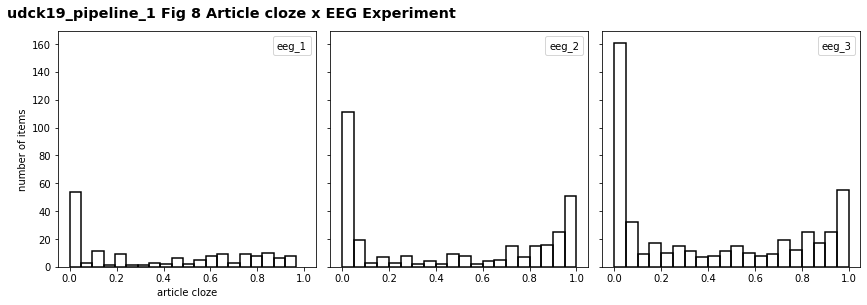

In [18]:
f, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True)
for axi, (expt, data) in enumerate(article_cloze_df.groupby(["expt"])):
    ax = axs[axi]
    if axi == 0:
        ax.set_ylabel("number of items")
        ax.set_xlabel("article cloze")
    ax.hist(
        data['article_cloze'],
        bins=20,
        label=expt,
        lw=1.5,
        facecolor='none',
        edgecolor='black'
    )
    leg = ax.legend(handlelength=0, handletextpad=0)
    for handle in leg.legendHandles:
        handle.set_visible(False)
        
sup_title = f"{FIG_PREFIX} {FIG_COUNT} Article cloze x EEG Experiment"
f.suptitle(sup_title, **FIG_TAG_SPECS)
f.tight_layout()
FIG_COUNT = udck19_figsave(f, sup_title, FIG_COUNT)


In [19]:
# log execution time
pipeline_stop = datetime.datetime.now()

elapsed =  pipeline_stop - pipeline_start
LOGGER.info(f"""
Done {pipeline_stop.strftime("%d.%b %Y %H:%M:%S")}
Elapsed time: {elapsed}
""")


udck19_pipeline_1.ipynb:INFO:
Done 15.Dec 2019 17:32:36
Elapsed time: 0:00:43.652946

